# Comparing supervised learning models for regression

- subset selection, partial least squares, ridge, lasso regression
- cross validation, feature importances, dimension reduction
- gradient boosting, random boosting, ensembles
- sklearn, statsmodels, St Louis Fed FRED, GDP

Terence Lim

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from pandas.api.types import is_list_like, is_numeric_dtype
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error    
import time
import os
from finds.alfred import Alfred, fred_qd
from settings import settings
imgdir = os.path.join(settings['images'], 'regression')
alf = Alfred(api_key=settings['fred']['api_key'])

# Get FRED-QD data

In [4]:
qdf, qt = fred_qd(202004)
df = qdf  #[list(qt.index[qt['factors']==1])]
t = qt['transform']
beg = 19620701
end = 20191231  # ignore 2020
freq = 'Q'   
transformed = []
for col in df.columns:
    transformed.append(alf.transform(df[col], tcode=t[col], freq=freq))
data = pd.concat(transformed, axis=1).iloc[2:]
c = list(data.columns)
data = data.loc[(data.index >= beg) & (data.index <= end)]

# Drop columns with missing data

In [5]:
missing = []
for series_id in df.columns:
    g = data[series_id].notna()
    missing.extend([(date, series_id) for date in data.index[~g]])
missing_per_row = data.isna().sum(axis=1)
missing = DataFrame.from_records(missing, columns=['date', 'series_id'])
print('original:', data.shape, 'non-missing', data.dropna(axis=1).shape)
data = data.dropna(axis=1)   # drop columns where missing values
print('Series dropped:')
DataFrame(missing['series_id'].value_counts())


original: (230, 248) non-missing (230, 217)
Series dropped:


,series_id
SPCS20RSA,151
EXUSEU,147
ACOGNO,119
SPCS10RSA,99
OUTMS,99
ULCMFG,99
COMPRMS,99
OPHMFG,99
HOAMS,99
USEPUINDXM,91


# Split time series train and test set
- train through 2014: test next five years (20 quarters) thru 2019. Ignoring 2020

In [6]:
# helper to split time series train and test sets
def ts_split(X, Y, end=20141231):
    return X[Y.index<=end], X[Y.index>end], Y[Y.index<=end], Y[Y.index>end]
Y = data['GDPC1'].iloc[1:]
X = data.shift(1).iloc[1:]
test = Series(name='test', dtype=float)    # collect test and train errors
train = Series(name='train', dtype=float)
final_models = {}                          # collect final fitted models
Y

19621231    0.003283
19630331    0.010857
19630630    0.011159
19630930    0.021746
19631231    0.006535
              ...   
20181231    0.002710
20190331    0.007623
20190630    0.004985
20190930    0.005204
20191231    0.005261
Name: GDPC1, Length: 229, dtype: float64

# Forward Selection

In [7]:
def forward_select(Y, X, selected, by='aic'):
    """helper to forward select next regressor"""
    remaining = [x for x in X.columns if x not in selected]
    results = []
    for x in remaining:
        r = sm.OLS(Y, X[selected + [x]]).fit()
        results.append({'select': x, 'aic': r.aic, 'bic': r.bic,
                        'rsquared': r.rsquared,
                        'rsquared_adj': r.rsquared_adj})
    return DataFrame(results).sort_values(by=by).iloc[0].to_dict()

# split train/test and forward select
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
tic = time.time()
selected = []
models = {}
by = 'bic'
for i in range(1, 32):
    select = forward_select(Y_train, X_train, selected, by=by)
    models.update({i: select})
    selected.append(select['select'])
selected = DataFrame.from_dict(models, orient='index')

# report best bic, and show selection criteria
best = selected[[by]].iloc[selected[by].argmin()]
subset = selected.loc[:best.name, 'select'].values
print('Subset Selected')
DataFrame.from_dict({n: {'series_id': s,
                         'description': alf.header(s)}
                     for n, s in selected.loc[:best.name, 'select'].items()},
                    orient='index').set_index('series_id')

Subset Selected


,description
series_id,
PCESV,Personal Consumption Expenditures: Services
PRFI,Private Residential Fixed Investment
TABSHNO,Households and Nonprofit Organizations; Total ...
IPNMAT,Industrial Production: Non-Durable Goods Mater...
AAAFFM,Moody's Seasoned Aaa Corporate Bond Minus Fede...
OPHPBS,Business Sector: Real Output Per Hour of All P...
TNWMVBSNNCBBDI,*** TNWMVBSNNCBBDI ***
TOTRESNS,Total Reserves of Depository Institutions
GPDICTPI,Gross Private Domestic Investment: Chain-type ...


## Plot BIC vs number selected

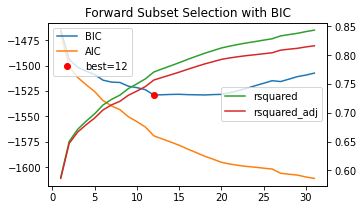

In [8]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(5,3))
selected['bic'].plot(ax=ax, c='C0')
selected['aic'].plot(ax=ax, c='C1')
ax.plot(best.name, float(best), "or")
ax.legend(['BIC', 'AIC', f"best={best.name}"], loc='upper left')
ax.set_title(f"Forward Subset Selection with {by.upper()}")
bx = ax.twinx()
selected['rsquared'].plot(ax=bx, c='C2')
selected['rsquared_adj'].plot(ax=bx, c='C3')
bx.legend(['rsquared', 'rsquared_adj'], loc='center right')
bx.set_xlabel('# Predictors')
plt.savefig(os.path.join(imgdir, 'forward.jpg'))
plt.show()

## evaluate train and test mse

In [9]:
model = sm.OLS(Y_train, X_train[subset]).fit()
name = f"Forward Subset Regression (k={len(subset)})"
test[name] = mean_squared_error(Y_test, model.predict(X_test[subset]))
train[name] = mean_squared_error(Y_train, model.predict(X_train[subset]))
final_models[name] = model
DataFrame({'name': name, 'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Forward Subset Regression (k=12),0.005353,0.00647


# Dimension Reduction: Partial Least Squares

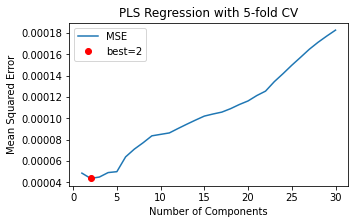

In [10]:
# - split train and test, fit standard scaling using train set
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

# fit with 5-fold CV to choose n_components
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
mse = Series(dtype=float)
for i in np.arange(1, 31):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale.transform(X_train), Y_train,
                            cv=kf, scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score

# show CV results and best model
fig, ax = plt.subplots(clear=True, num=1, figsize=(5,3))
mse.plot(ylabel='Mean Squared Error', xlabel='Number of Components',
         title=f"PLS Regression with {n_splits}-fold CV", ax=ax)
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['MSE', f"best={best}"])
plt.savefig(os.path.join(imgdir, 'pls.jpg'))
plt.show()

# evaluate train and test mse

In [11]:
model = PLSRegression(n_components=best).fit(X_train, Y_train)
name = f"PLS Regression"
test[name] = mean_squared_error(Y_test, model.predict(X_test))
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model
DataFrame({'name': name, 'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,PLS Regression,0.005983,0.002889


# Ridge Regression
- Plot fitted coefficients (of forward selected subset) vs regularization

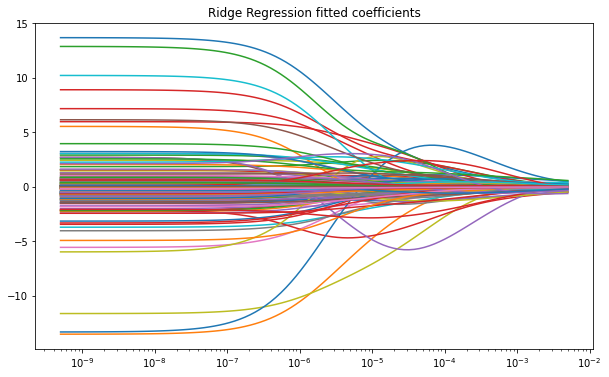

In [27]:
from sklearn.linear_model import Ridge, RidgeCV
alphas = 10**np.linspace(-2, -9, 100)*0.5  # for parameter tuning
X_train, X_test, Y_train, Y_test = ts_split(X, Y)

# Ridge Regression -- plot coefficients
coefs = [Ridge(normalize=True, alpha=alpha)\
         .fit(X_train, Y_train).coef_ for alpha in alphas]
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_title('Ridge Regression fitted coefficients')
plt.savefig(os.path.join(imgdir, 'ridge.jpg'))
plt.show()

## RidgeCV Leave One Out Cross Validation LOOCV

In [13]:
model = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error',
                normalize=True, store_cv_values=True).fit(X_train, Y_train)
name = f"Ridge (alpha={model.alpha_:.3g})"
test[name] = mean_squared_error(Y_test, model.predict(X_test))
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model
DataFrame({'name': name, 'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Ridge (alpha=2.32),0.005353,0.003089


# Lasso Regression
- Plot fitted coefficients (of forward selected subset) vs regularization

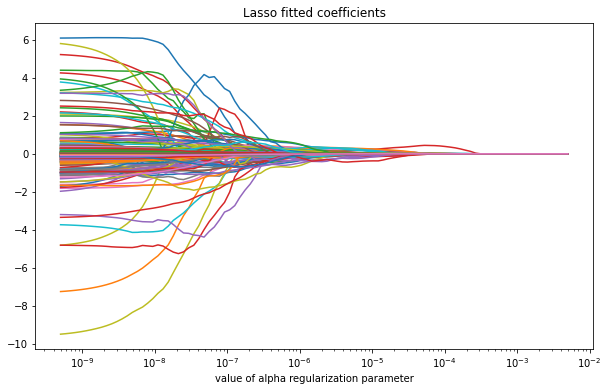

In [29]:
from sklearn.linear_model import Lasso, LassoCV
alphas = 10**np.linspace(-2, -9, 100)*0.5  # for parameter tuning
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
    
# Plot fitted coefficients vs regularization
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    coefs = [Lasso(max_iter=100000, normalize=True, alpha=alpha)\
             .fit(X_train, Y_train).coef_  for alpha in alphas]
fig, ax = plt.subplots(num=3, clear=True, figsize=(10,6))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('value of alpha regularization parameter')
ax.set_title('Lasso fitted coefficients')
plt.savefig(os.path.join(imgdir, 'lasso.jpg'))
plt.show()

## LassoCV 10-Fold CV

In [15]:
model = LassoCV(alphas=None, cv=10, normalize=True, n_jobs=-1,
                max_iter=30000).fit(X_train, Y_train)
name = f"Lasso (alpha={model.alpha_:.3g})"
test[name] = mean_squared_error(Y_test, model.predict(X_test))
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model
DataFrame({'name': name, 'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Lasso (alpha=2.94e-05),0.005118,0.003456


In [16]:
# Display nonzero coefs

In [17]:
nonzero = np.sum(np.abs(model.coef_) > 0)
argsort = np.flip(np.argsort(np.abs(model.coef_)))[:nonzero]
DataFrame({'series_id': X_train.columns[argsort],
           'desc': [alf.header(s) for s in X_train.columns[argsort]],
           'coef': model.coef_[argsort]}).round(6).set_index('series_id')

,desc,coef
series_id,,
PCESV,Personal Consumption Expenditures: Services,0.363869
DHUTRG3Q086SBEA,Personal consumption expenditures: Services: H...,0.136107
USGOVT,"All Employees, Government",0.103085
GPDICTPI,Gross Private Domestic Investment: Chain-type ...,0.100673
TLBSNNCBBDI,*** TLBSNNCBBDI ***,-0.097184
OPHPBS,Business Sector: Real Output Per Hour of All P...,-0.091268
DRCARG3Q086SBEA,Personal consumption expenditures: Recreation ...,-0.079822
DPIC96,Real Disposable Personal Income,0.053718
SRVPRD,"All Employees, Service-Providing",0.053017


# Gradient boost
- 5-fold cross validation

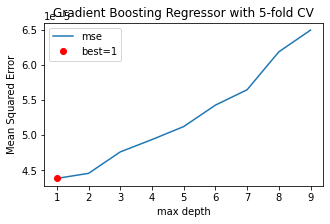

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
X_train, X_test, Y_train, Y_test = ts_split(X, Y)

# tune max_depth with 5-fold CV
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
mse = Series(dtype=float)
for i in range(1, 10): # tune max_depth for best performance
    boosted = GradientBoostingRegressor(max_depth=i, random_state=0)
    score = cross_val_score(boosted, X_train, Y_train, cv=kf,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score

fig, ax = plt.subplots(clear=True, num=1, figsize=(5,3))
mse.plot(ax=ax, ylabel='Mean Squared Error', xlabel='max depth',
         title=f"Gradient Boosting Regressor with {n_splits}-fold CV")
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['mse', f"best={best}"])
plt.savefig(os.path.join(imgdir, 'boosting.jpg'))
plt.show()

## evaluate train and test MSE

In [19]:
name = f"Boosting (depth={best})"
model = GradientBoostingRegressor(max_depth=best,
                                  random_state=0).fit(X_train, Y_train)
test[name] = mean_squared_error(Y_test, model.predict(X_test))
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model
DataFrame({'name': name, 'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Boosting (depth=1),0.004117,0.002985


## show feature importance

In [20]:
top_n = 15
imp = Series(model.feature_importances_, index=X.columns).sort_values()
DataFrame.from_dict({i+1: {'importance': imp[s],
                           'series_id': s,
                           'description': alf.header(s)}
                     for i, s in enumerate(np.flip(imp.index[-top_n:]))},
                    orient='index')

,importance,series_id,description
1,0.207150,PCESV,Personal Consumption Expenditures: Services
2,0.116278,CPF3MTB3M,3-Month Commercial Paper Minus 3-Month Treasur...
3,0.092490,PERMIT,New Private Housing Units Authorized by Buildi...
4,0.067246,PRFI,Private Residential Fixed Investment
5,0.051884,IMPGSC1,Real imports of goods and services
6,0.046484,FPI,Fixed Private Investment
7,0.046227,TABSHNO,Households and Nonprofit Organizations; Total ...
8,0.038551,MANEMP,"All Employees, Manufacturing"
9,0.027570,HWIURATIO,Ratio of Help Wanted/No. Unemployed
10,0.017259,INDPRO,Industrial Production: Total Index


# Random Forest
- 5-fold Cross Validation

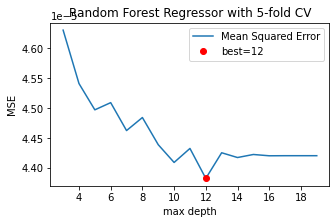

In [21]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, Y_train, Y_test = ts_split(X, Y)

# tune max_depth with 5-fold CV
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
mse = Series(dtype=float)
for i in range(3, 20): #tune for best performance
    model = RandomForestRegressor(max_depth=i, random_state=0)
    score = cross_val_score(model, X_train, Y_train, cv=kf,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score

fig, ax = plt.subplots(clear=True, num=1, figsize=(5,3))
mse.plot(ax=ax, ylabel='MSE', xlabel='max depth',
         title=f"Random Forest Regressor with {n_splits}-fold CV")
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['Mean Squared Error', f"best={best}"])
plt.savefig(os.path.join(imgdir, 'randomforest.jpg'))
plt.show()

## Evaluate train and test error

In [22]:
name = f"RandomForest (depth={best})"
model = RandomForestRegressor(max_depth=best,
                              random_state=0).fit(X_train, Y_train)
test[name] = mean_squared_error(Y_test, model.predict(X_test))
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model
DataFrame({'name': name, 'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,RandomForest (depth=12),0.002442,0.002703


## show top feature Importances

In [23]:
top_n = 15
imp = Series(model.feature_importances_, index=X.columns).sort_values()
DataFrame.from_dict({i+1: {'importance': imp[s],
                           'series_id': s,
                           'description': alf.header(s)}
                     for i, s in enumerate(np.flip(imp.index[-top_n:]))},
                    orient='index')


,importance,series_id,description
1,0.128560,PCESV,Personal Consumption Expenditures: Services
2,0.082498,CPF3MTB3M,3-Month Commercial Paper Minus 3-Month Treasur...
3,0.053298,PERMIT,New Private Housing Units Authorized by Buildi...
4,0.040920,HWIURATIO,Ratio of Help Wanted/No. Unemployed
5,0.037393,PRFI,Private Residential Fixed Investment
6,0.031916,FPI,Fixed Private Investment
7,0.024220,IMPGSC1,Real imports of goods and services
8,0.018111,TABSHNO,Households and Nonprofit Organizations; Total ...
9,0.017194,PCECC96,Real Personal Consumption Expenditures
10,0.015739,CLAIMS,Initial Claims


# Plot summary of all model RMSE's

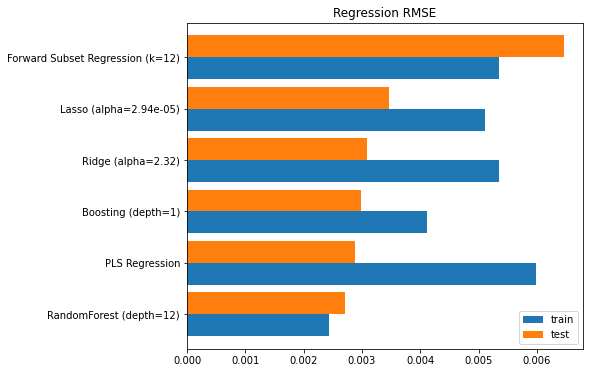

In [24]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
np.sqrt(train.rename('train').to_frame().join(test.rename('test')))\
  .sort_values('test').plot.barh(ax=ax, width=0.85)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_title('Regression RMSE')
ax.figure.subplots_adjust(left=0.35)
plt.savefig(os.path.join(imgdir, 'rmse.jpg'))
plt.show()
    